In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# nltk
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to C:\Users\Jeferson
[nltk_data]     Poma\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


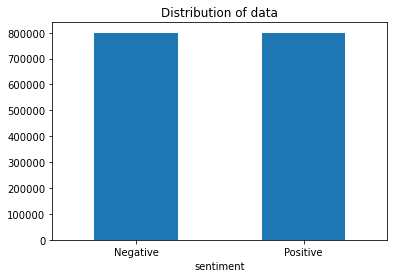

In [2]:
# Importing the dataset
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
dataset = pd.read_csv('training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS)

# Removing the unnecessary columns.
dataset = dataset[['sentiment','text']]
# Replacing the values to ease understanding.
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Plotting the distribution for dataset.
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)

# Storing data in lists.
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [3]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [4]:
def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            #if word not in stopwordlist:
            if len(word)>1:
                # Lemmatizing the word.
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [5]:
import time
t = time.time()
processedtext = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 358 seconds


**Word-Cloud for Negative tweets**

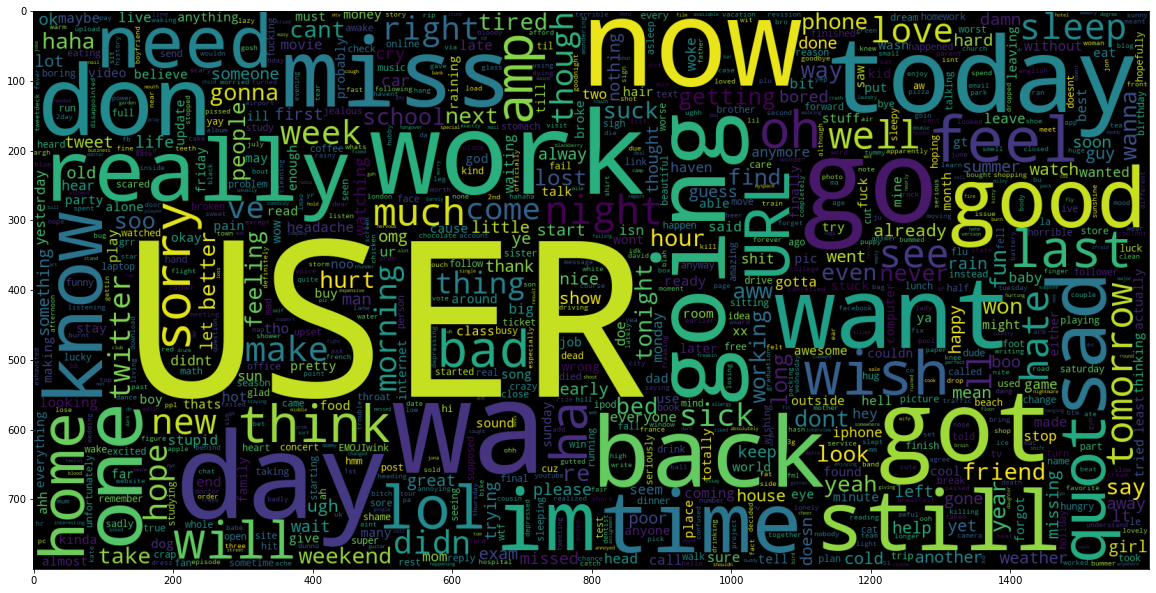

In [6]:
data_neg = processedtext[:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

**Word-Cloud for Positive tweets**

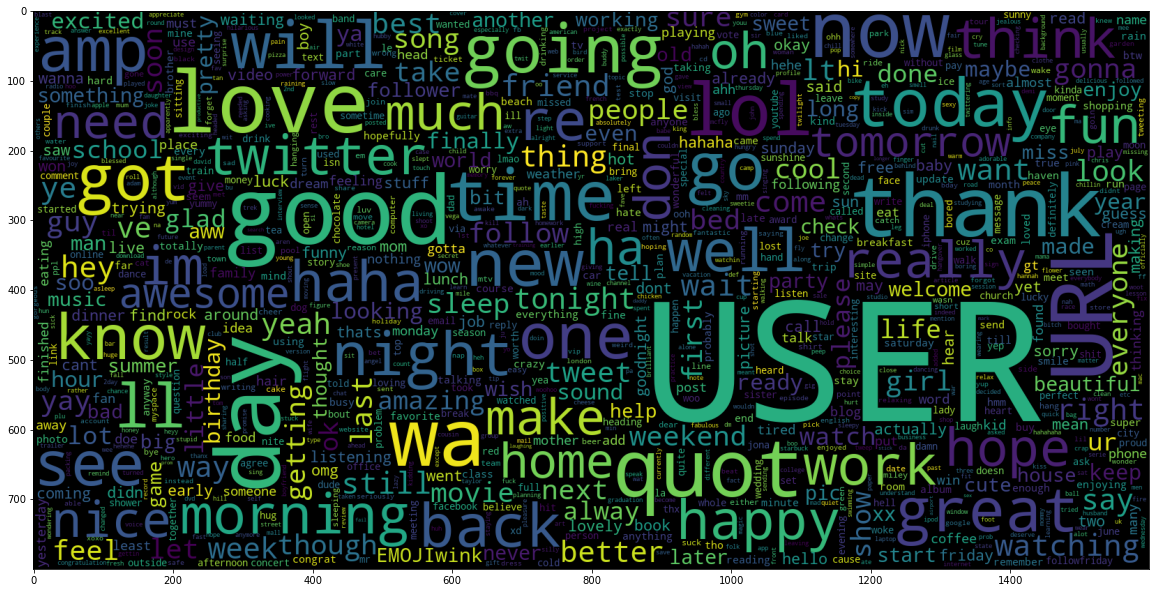

In [7]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

**Splitting the Data**

In [8]:
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


*NOTA: hasta aqui, todavia se encuentra el TWEET y su CLASE*

### "TF-IDF Vectoriser"

In [10]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=50000) #500000 a 50000
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  50000


**Transforming the dataset  ??**

In [11]:
X_trainVector = vectoriser.transform(X_train)
X_testVector  = vectoriser.transform(X_test)
print(f'Data Transformed.')


Data Transformed.


In [12]:
import numpy as np
from scipy.sparse import csr_matrix

X_testVector=X_testVector[:5000]
y_test=y_test[:5000]
X_test=X_test[:5000]
X_testVector=X_testVector.todense()


# ACA TERMINA EL TF-IDF

In [14]:
X_testVector=X_testVector[:10000]
y_test=y_test[:10000]
X_test=X_test[:10000]

In [6]:
#print(X_testVector.shape,";",len(y_test),";",len(X_test),";")

import numpy as np
from scipy.sparse import csr_matrix

A = np.array([[1, 0, 0, 0, 0, 0], [0, 0, 2, 0, 0, 1], [0, 0, 0, 2, 0, 0]])
print("Dense matrix representation: \n", A)

# convert to sparse matrix representation 
S = csr_matrix(A)
print("Sparse matrix: \n",S)

# convert back to 2-D representation of the matrix
B = S.todense()
print("Dense matrix: \n", B)

Dense matrix representation: 
 [[1 0 0 0 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]
Sparse matrix: 
   (0, 0)	1
  (1, 2)	2
  (1, 5)	1
  (2, 3)	2
Dense matrix: 
 [[1 0 0 0 0 0]
 [0 0 2 0 0 1]
 [0 0 0 2 0 0]]


In [ ]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components = 2)
data2D = svd.fit(X_testVector).transform(X_testVector)

new_df = pd.DataFrame(data = data2D , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
new_df=new_df[:20000]

new_df.to_csv('svd.csv',index=False)

In [ ]:
#  ******* T-SNE  ********
from sklearn.manifold import TSNE
#https://www.youtube.com/watch?v=su6amJTXnto

tsne = TSNE(n_components=2, perplexity=100, random_state=42)   #2,100,42
data2D = tsne.fit_transform(X_testVector)

new_df = pd.DataFrame(data = data2D , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
new_df=new_df[:20000]

new_df.to_csv('tsne.csv',index=False)

In [11]:
#  *******  ISOMAP  ********
from sklearn.manifold import Isomap


iso = Isomap(n_components=2)
x_new = iso.fit(X_testVector).transform(X_testVector)

new_df = pd.DataFrame(data = x_new , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
#new_df=new_df[:20000]

new_df.to_csv('iso.csv',index=False)

In [10]:
#  *******  kernel PCA  ********
from sklearn.decomposition import KernelPCA
#https://www.youtube.com/watch?v=1iA8Vte447k

kernelPCA = KernelPCA(n_components=2)
x_new=kernelPCA.fit_transform(X_testVector)

new_df = pd.DataFrame(data = x_new , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
#new_df=new_df[:20000]

new_df.to_csv('kpca.csv',index=False)

RuntimeError: nnz of the result is too large

In [13]:
# *******  SRP  ********
from sklearn.random_projection import SparseRandomProjection

srp = SparseRandomProjection(n_components = 2)
x_new = srp.fit_transform(X_testVector)

new_df = pd.DataFrame(data = x_new , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
#new_df=new_df[:20000]

new_df.to_csv('srp.csv',index=False)

In [ ]:
# *****  GRP  ******
from sklearn.random_projection import GaussianRandomProjection

grp = GaussianRandomProjection(n_components=2)
x_new = grp.fit_transform(X_testVector)

new_df = pd.DataFrame(data = x_new , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
new_df=new_df[:20000]

new_df.to_csv('grp.csv',index=False)

In [12]:
#  ****** Incremental PCA ********
from sklearn.decomposition import IncrementalPCA

ipca = IncrementalPCA(n_components=2)
x_new = ipca.fit_transform(X_testVector)

new_df = pd.DataFrame(data = x_new , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
#new_df=new_df[:20000]

new_df.to_csv('ipca.csv',index=False)

MemoryError: Unable to allocate 298. GiB for an array with shape (80000, 500000) and data type float64

In [14]:
# ******* SPARCE PCA *******
from sklearn.decomposition import SparsePCA

spca = SparsePCA(n_components=2)
x_new = spca.fit_transform(X_testVector)

new_df = pd.DataFrame(data = x_new , columns = ['x', 'y'])
new_df['clase']=y_test
new_df['content']=X_test
new_df=new_df[['clase','x','y','content']]
#new_df=new_df[:20000]

new_df.to_csv('spca.csv',index=False)

In [ ]:
print(data2D[0])
#print(X_test[0])
print(y_test)

### K-Means

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(X_test)
centers2D = svd.transform(kmeans.cluster_centers_)

plt.scatter(centers2D[:,0], centers2D[:,1], 
            marker='x', s=200, linewidths=3, c='r')

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit(X_test)
data2D = pca.transform(X_test)
plt.scatter(data2D[:,0], data2D[:,1])